in the last few weeks I worked on this and tried many different model architectures, loss functions, training strategies. As you might know, when we load an image, we get a rank-3 (height, width, color) array with the last axis containing the color data for our image. These data represent color in RGB color space and there are 3 numbers for each pixel indicating how much Red, Green, and Blue the pixel is.
In L*a*b color space, we have again three numbers for each pixel but these numbers have different meanings. The first number (channel), L, encodes the Lightness of each pixel and when we visualize this channel (the second image in the row below) it appears as a black and white image. The *a and *b channels encode how much green-red and yellow-blue each pixel is, respectively. In the following image you can see each channel of L*a*b color space separately.
In all papers I studied and all codes I checked out on colorization on GitHub, people use L*a*b color space instead of RGB to train the models. There are a couple of reasons for this choice but I'll give you an intuition of why we make this choice. To train a model for colorization, we should give it a grayscale image and hope that it will make it colorful. When using L*a*b, we can give the L channel to the model (which is the grayscale image) and want it to predict the other two channels (*a, *b) and after its prediction, we concatenate all the channels and we get our colorful image. But if you use RGB, you have to first convert your image to grayscale, feed the grayscale image to the model and hope it will predict 3 numbers for you which is a way more difficult and unstable task due to the many more possible combinations of 3 numbers compared to two numbers. If we assume we have 256 choices (in a 8-bit unsigned integer image this is the real number of choices) for each number, predicting the three numbers for each of the pixels is choosing between 256³ (each cell is a number between 0-255)combinations which is more than 16 million choices, but when predicting two numbers we have about 65000(256**2) choices (actually, we are not going to wildly choose these numbers like a classification task and I just wrote these numbers to give you an intuition).


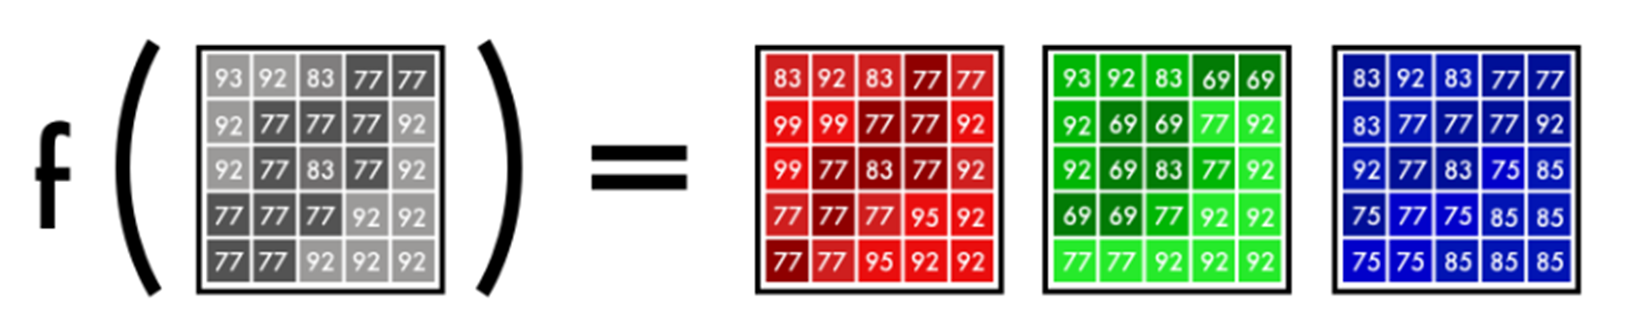

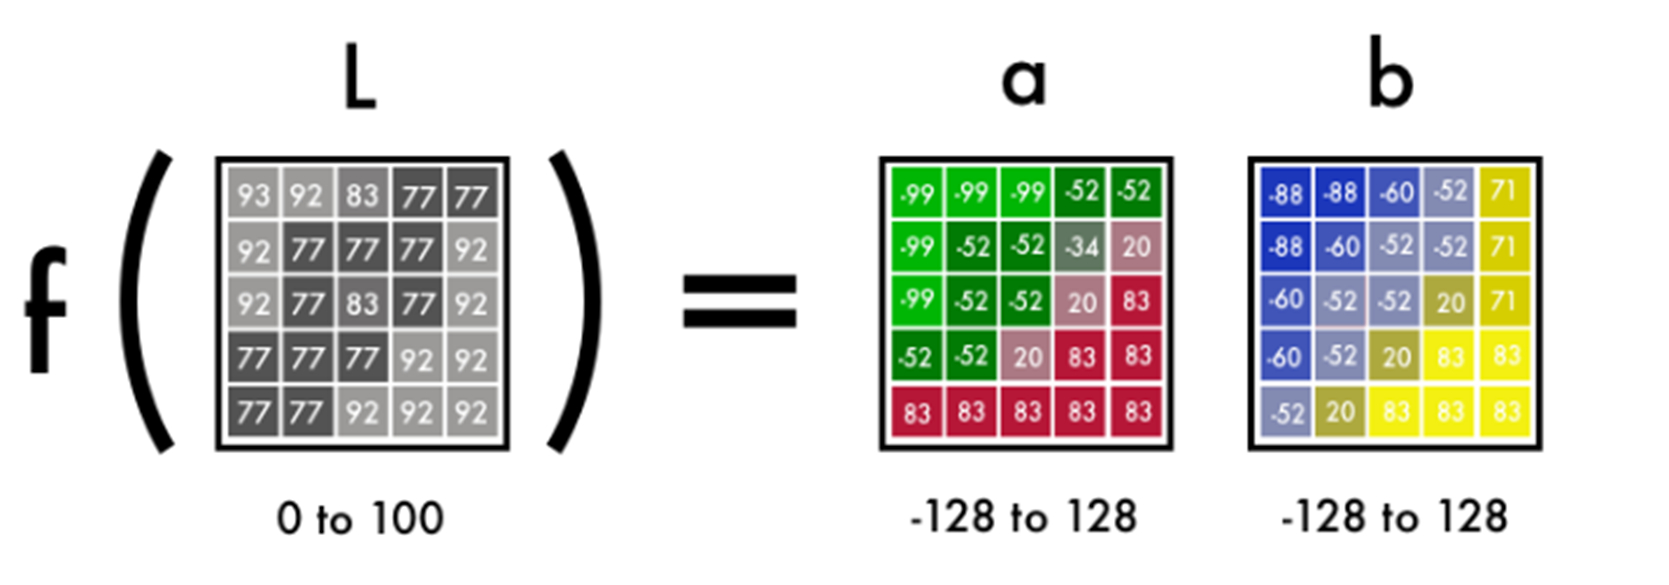

## What is GAN?
A generative adversarial network or "GAN" is a neural network consisting of two submodels. These models work together to generate something, which could be an image or even music, that to humans seems like the "real" thing.
The first submodel is the "Generator" and the second is the "Discriminator." After being pre-trained on what is real and what is noise, the Discriminator trains the Generator by revealing to it when it has created something realistic and when it hasn't. At first, the Generator will produce mostly noise, but eventually, it will generate realistic results.
There are lots of types of GANs that researchers have given creative names to, such as DCGANs, HyperGans, CycleGANs, and S^2-GANs.
The goal of the Generator is to create content so indistinguishable from the training set that the Discriminator cannot tell the difference.
Below is the structure of the Generator in gan_32.py. The structure used in gan_256.py is similar, but much deeper to account for the images being 256x256 instead of 32x32.


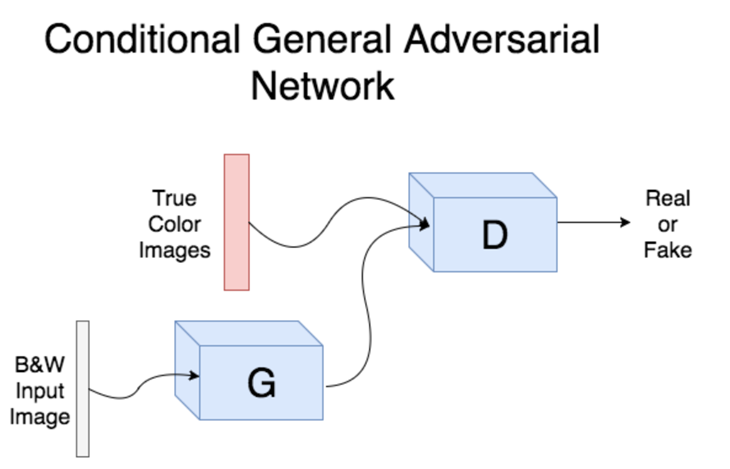

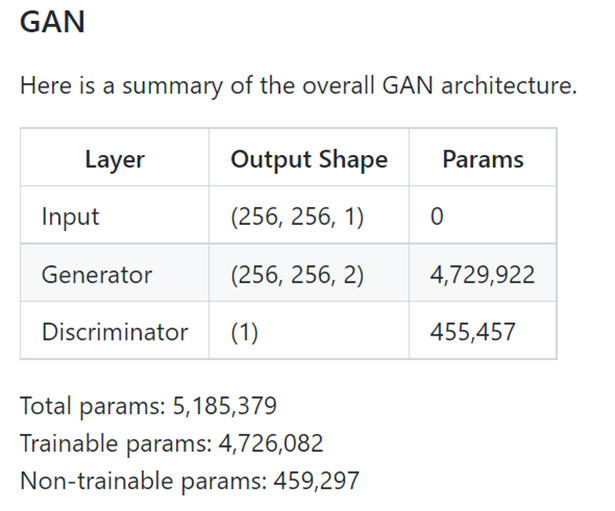

### what is the model? Classification or Regression? 

During the last few years, many different solutions have been proposed to colorize images by using deep learning. Colorful Image Colorization paper approached the problem as a classification task and they also considered the uncertainty of this problem (e.x. a car in the image can take on many different and valid colors and we cannot be sure about any color for it); however, another paper approached the problem as a regression task (with some more tweaks!). There are pros and cons to each approach but in this article, we are going to use a different strategy.
Image-to-Image Translation with Conditional Adversarial Networks paper, which you may know by the name pix2pix, proposed a general solution to many image-to-image tasks in deep learning which one of those was colorization. In this approach two losses are used:

*L1 loss, which makes it a regression task, and an adversarial (GAN) loss, which helps to solve the problem in an unsupervised manner (by assigning the outputs a number indicating how "real" they look!).*

we are going to build a GAN (a conditional GAN to be specific) and use an extra loss function, L1 loss.

the generator model takes a grayscale image (1-channel image) and produces a 2-channel image, a channel for *a and another for *b. 

The discriminator, takes these two produced channels and concatenates them with the input grayscale image and decides whether this new 3-channel image is fake or real. Of course the discriminator also needs to see some real images (3-channel images again in Lab color space) that are not produced by the generator and should learn that they are real.


 I'm using only 8,000 images from COCO dataset for training which I had available on my device.
You can use almost any dataset for this task as far as it contains many different scenes and locations which you hope it will learn to colorize.
We need fastai here only to download part of COCO dataset.

### Data augmentation:
I hope the code is self-explanatory. I'm resizing the images and flipping horizontally (flipping only if it is training set) and then I read an RGB image, convert it to Lab color space and separate the first (grayscale) channel and the color channels as my inputs and targets for the models respectively. Then I'm making the data loaders.

 L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
  
 ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
 
 batch_size=16, n_workers=4


## Generator:
Generator proposed by the paper:

we have implemented a U-Net to be used as the generator of our GAN.
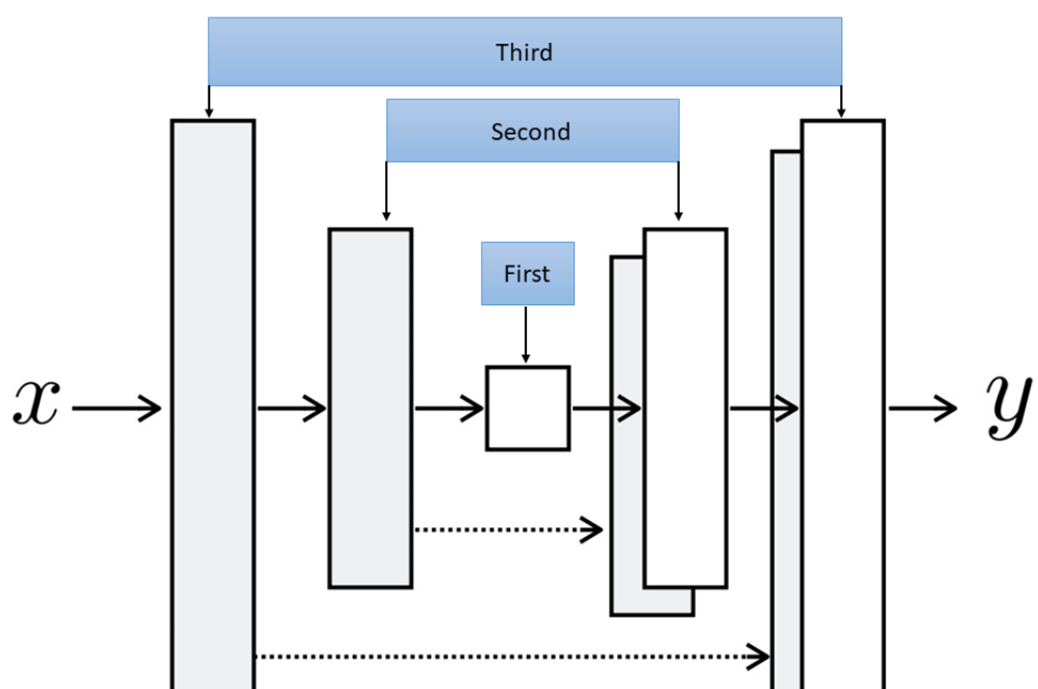

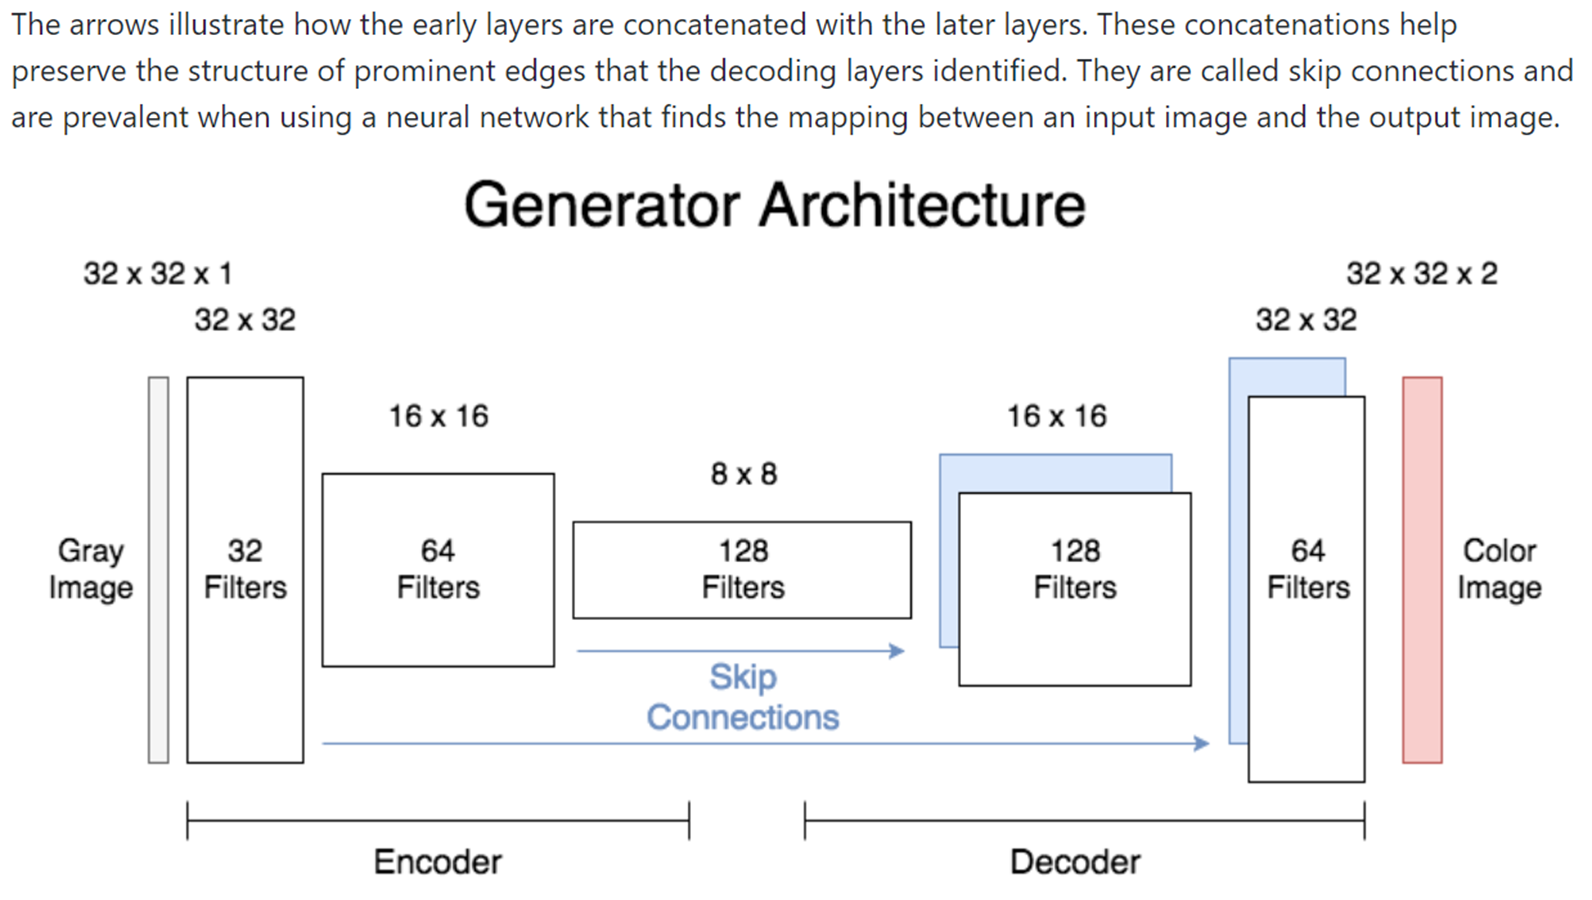

### Discriminator
The architecture of our discriminator is rather straight forward. This code implements a model by stacking blocks of Conv-BatchNorm-LeackyReLU to decide whether the input image is fake or real. Notice that the first and last blocks do not use normalization and the last block has no activation function (it is embedded in the loss function we will use).

We are using a "Patch" Discriminator here. Okay, what is it?! In a vanilla discriminator, the model outputs one number (a scaler) which represents how much the model thinks the input (which is the whole image) is real (or fake). In a patch discriminator, the model outputs one number for every patch of say 70 by 70 pixels of the input image and for each of them decides whether it is fake or not separately. Using such a model for the task of colorization seems reasonable to me because the local changes that the model needs to make are really important and maybe deciding on the whole image as in vanilla discriminator cannot take care of the subtleties of this task. Here, the model's output shape is 30 by 30 but it does not mean that our patches are 30 by 30. The actual patch size is obtained when you compute the receptive field of each of these 900 (30 multiplied by 30) output numbers which in our case will be 70 by 70


The whole work is being done in optimize method of this class. First and only once per iteration (batch of training set) we call the module's forward method and store the outputs in fake_color variable of the class.
Then, we first train the discriminator by using backward_D method in which we feed the fake images produced by generator to the discriminator (make sure to detach them from the generator's graph so that they act as a constant to the discriminator, like normal images) and label them as fake. Then we feed a batch of real images from training set to the discriminator and label them as real. We add up the two losses for fake and real and take the average and then call the backward on the final loss. Now, we can train the generator.


In backward_G method we feed the discriminator the fake image and try to fool it by assigning real labels to them and calculating the adversarial loss. As I mentioned earlier, we use L1 loss as well and compute the distance between the predicted two channels and the target two channels and multiply this loss by a coefficient (which is 100 in our case) to balance the two losses and then add this loss to the adversarial loss. Then we call the backward method of the loss.

As you can see, although this baseline model has some basic understanding of some most common objects in images like sky, trees, … its output is far from something appealing and it cannot decide on the color of rare objects. It also displays some color spillovers and circle-shaped mass of color (center of first image of second row) which is not good at all. So, it seems like that with this small dataset we cannot get good results with this strategy. Therefore, we change our strategy!
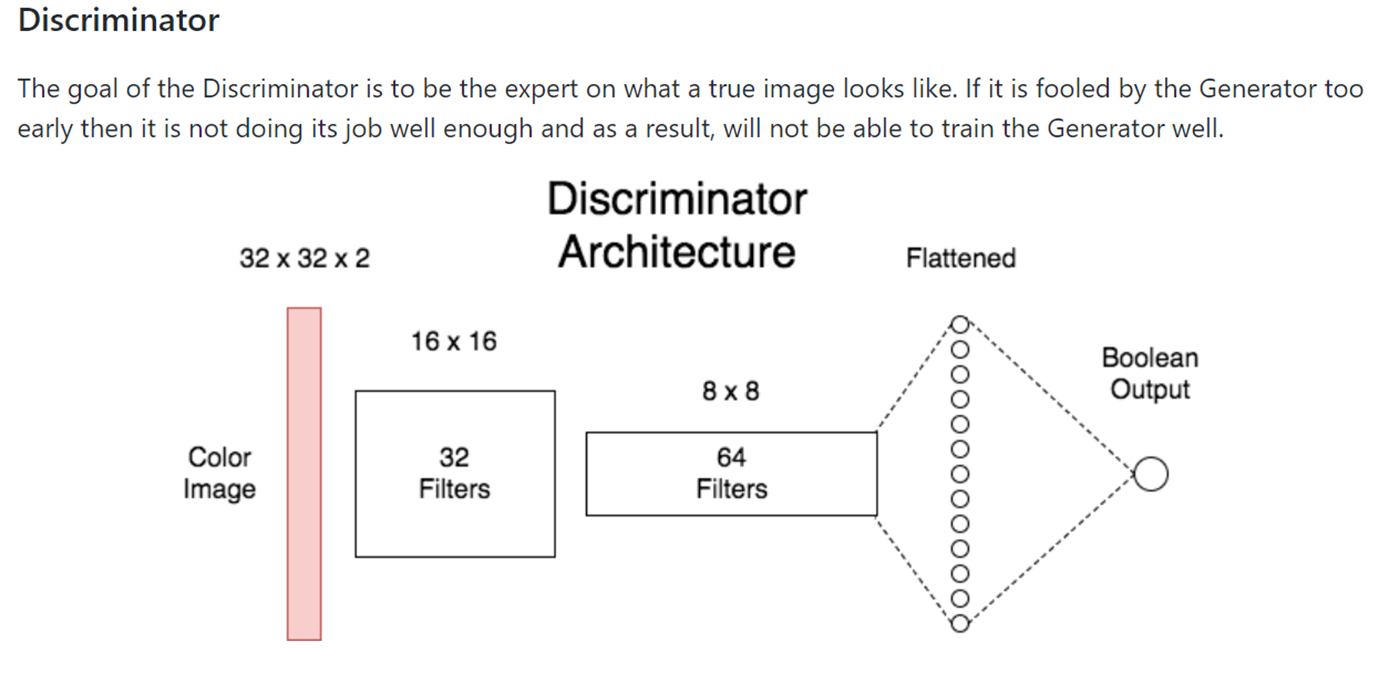

Here is the focus of this article and where I'm going to explain what I did to overcome the last mentioned problem. Inspired by an idea in Super Resolution literature, I decided to pretrain the generator separately in a supervised and deterministic manner to avoid the problem of "the blind leading the blind" in the GAN game where neither generator nor discriminator knows anything about the task at the beginning of training.
Actually I use pretraining in two stages: 1- The backbone of the generator (the down sampling path) is a pretrained model for classification (on ImageNet) 2- The whole generator will be pretrained on the task of colorization with L1 loss.
In fact, I'm going to use a pretrained ResNet18 as the backbone of my U-Net and to accomplish the second stage of pretraining, we are going to train the U-Net on our training set with only L1 Loss. Then we will move to the combined adversarial and L1 loss, as we did in the previous section.


The goal of training is to keep the discriminator accuracy near 100% and make sure that the generator loss doesn't drop to 0. If the generator loss drops to 0 then it is fooling the discriminator with bad colorizations. This graph only shows 30 epochs and the results of this training run are the mountain images shown in my Results section.


Below is a graph showing generator loss in blue and discriminator accuracy in red
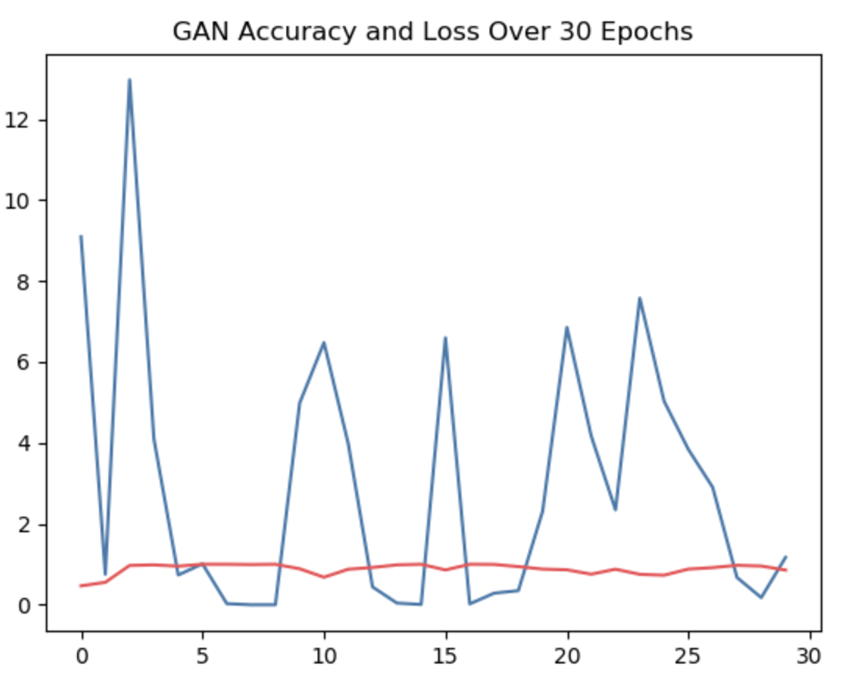

# Waht is FID score?
The Frechet Inception Distance score, or FID for short, is a metric that calculates the distance between feature vectors calculated for real and generated images.
The score summarizes how similar the two groups are in terms of statistics on computer vision features of the raw images calculated using the inception v3 model used for image classification. Lower scores indicate the two groups of images are more similar, or have more similar statistics, with a perfect score being 0.0 indicating that the two groups of images are identical. The FID score is used to evaluate the quality of images generated by generative adversarial networks, and lower scores have been shown to correlate well with higher quality images.


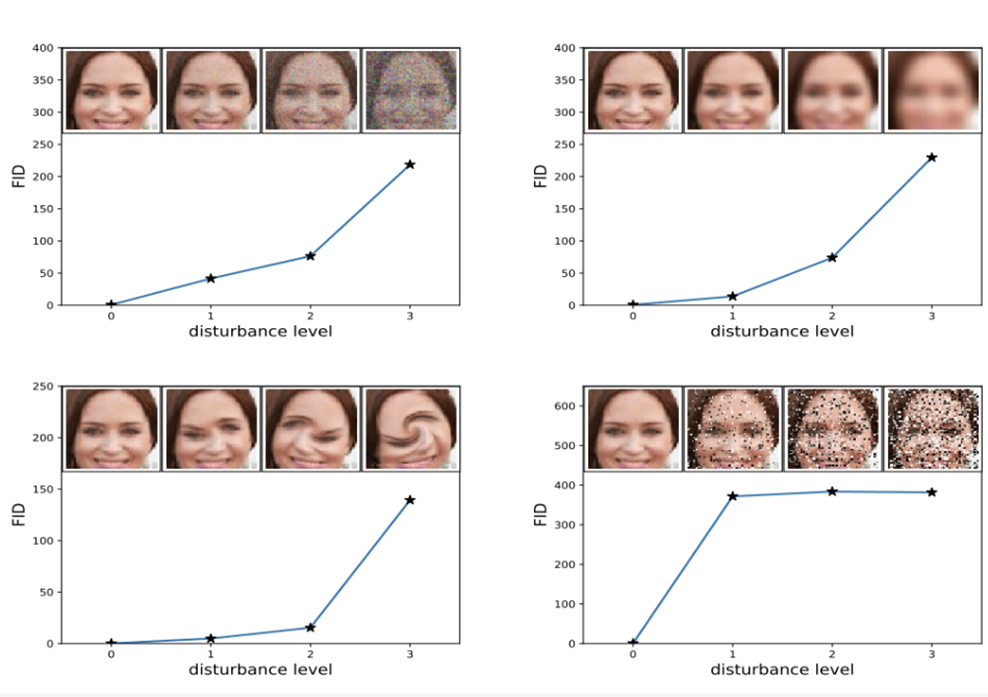

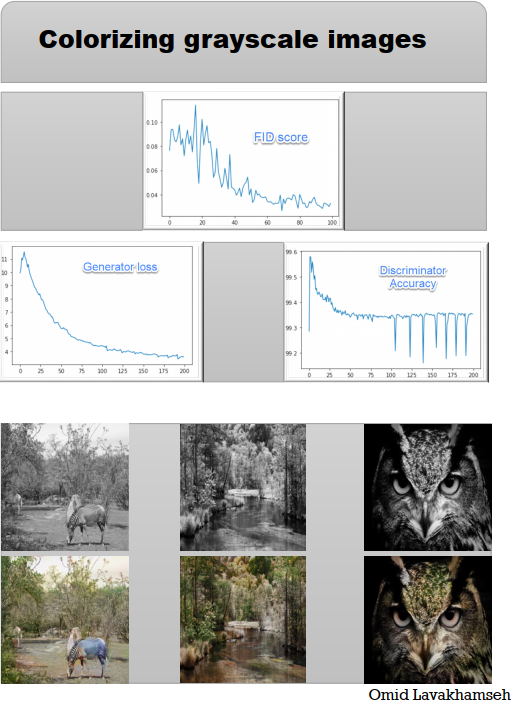